In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.realpath('..'))

In [2]:
import numpy as np
import plotly.express as ex
import plotly.graph_objects as go
import pandas as pd
import scipy as sp
import cache_magic

from tracking.motion import ConstantVelocityModel
from tracking.space import CartesianPositionVelocity, RbeSpace
from tracking.target import ConstantVelocityTarget
from tracking.util import to_df, colorscale

%cache magic is now registered in ipython


## Transform functions

In [3]:
def h(cart):
    sq = np.power(cart, 2)
    r  = np.sqrt(sq.sum(axis=0))
    rh = np.sqrt(sq[:, :2].sum(axis=0))

    az = np.arctan2(cart[1, :], cart[0, :])
    el = np.arctan2(cart[2, :], rh)

    rbe = np.array((r, az, el)).T
    return rbe

def h_inv(rbe):
    r, b, e = rbe[0], rbe[1], rbe[2]
    z = r * np.sin(e)
    x2y2 = r * np.cos(e)
    x = x2y2 * np.cos(b)
    y = x2y2 * np.sin(b)    
    return np.array((x, y, z)).T

def jacobian(x0):
    x, y, z = x0

    x2y2 = x**2 + y**2
    x2y2z2 = x2y2 + z**2
    
    r = np.sqrt(x2y2z2)
    t = np.sqrt(x2y2)
    u = t * x2y2z2

    # range, bearing, elevation
    return np.array([
        [x/r, y/r, z/r],
        [-y/x2y2, x/x2y2, 0],
        [-x*z/u, -y*z/u, t/x2y2z2]
    ])

## Extended Kalman Filter

In [31]:
class ExtendedKalmanFilter(object):
    def __init__(self):
        self.state_dim = 6
        self.meas_dim = 3
        self.motion_model = ConstantVelocityModel()

        self.x = np.zeros((self.state_dim, 1)) # column vector
        self.P = np.eye(self.state_dim)
        self.v = None # innovation
        self.S = None # covariance matrix associated with the innovation

    def initialize(self, z, R):
        z, R = np.array(z).squeeze(), np.array(R).squeeze()
        r, c = R.shape

        assert r == c
        assert r == len(z)
        
        self.x[:3,0] = h_inv(z)

        H = self.H()[:r, :c]
        H = np.linalg.inv(H)
        
        self.P[:r,:c] = H @ R @ H.T
    
    def predict(self, dt):
        F = self.motion_model.F(dt)
        Q = self.motion_model.Q(dt)
        
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + Q

    # measurement matrix
    def H(self):
        J = jacobian(self.x[:3, 0])
        H = np.zeros((self.meas_dim, self.state_dim))
        H[:3, :3] = J
        return H

    def update(self, z, R):
        z = np.array(z); z.shape = (self.meas_dim, 1) # measurement, column vector
        
        z_hat = h(self.x[:3, :])
        z_hat.shape = (self.meas_dim, 1)

        H = self.H()

        # innovation covariance
        # S = H*P*H + R
        S = H @ self.P @ H.T + R

        # Kalman gain
        # K = P*H (H*P*H + R)^-1
        K = self.P @ H.T @ np.linalg.inv(S)

        innovation = z - z_hat
        
        # filtered state (mean)
        # X = X + K(z - H*X)
        x = self.x + K @ innovation
        
        # filtered state (covariance)
        # P = P - K*S*K
        P = self.P - K @ S @ K.T

        self.x = x
        self.P = P
        self.v = innovation
        self.S = S

## Test

Simulate a target flying in a straight line, generating RBE detections.

In [5]:
def rbe_measurements(positions, noise_covariance=[10, .1, .1], seed=0):
    rbe = RbeSpace().from_cartesian(positions)
    if noise_covariance is None:
        return rbe
        
    noise_covariance = np.array(noise_covariance)
    if len(noise_covariance.shape) == 1:
        noise_covariance = np.diag(noise_covariance)

    noise_mean = np.full(rbe.shape[1], 0)
    rnd = np.random.default_rng(seed=seed)
    noise = rnd.multivariate_normal(noise_mean, noise_covariance, size=rbe.shape[0])
    assert rbe.shape == noise.shape
    
    return rbe + noise

In [6]:
target = ConstantVelocityTarget(initial_position=[-5000, 1000, 0])
truth = target.true_states(n=401)

meas_cov = np.diag([1, 0.0007, 0.0007]) # var=0.0007 rad^2 -> sd = 1.5 deg
measurements = rbe_measurements(truth[:,:3], noise_covariance=meas_cov)

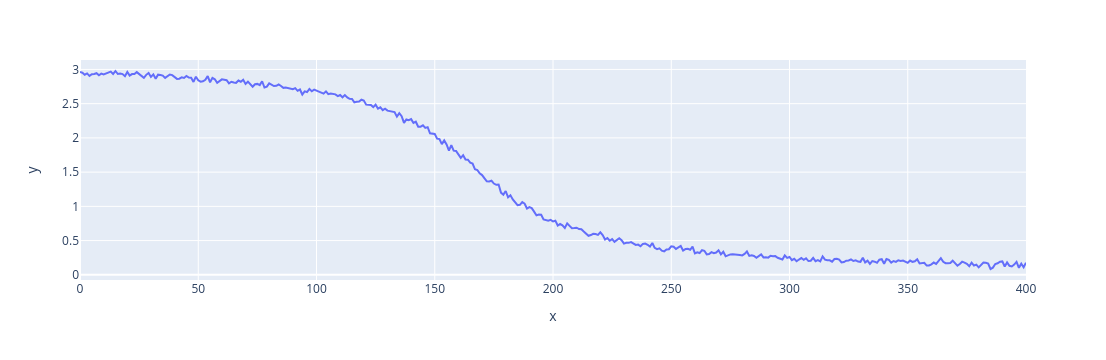

In [7]:
ex.line(y=measurements[:,1])

In [8]:
x_hat, P_hat = [], []
MC_runs = 500

for run in range(MC_runs):

    measurements = rbe_measurements(truth[:,:3], noise_covariance=meas_cov, seed=run)
    x_run, P_run = [], []
    
    kf = ExtendedKalmanFilter()
    kf.initialize(measurements[0,:], meas_cov)
    
    for z in measurements[1:,:]:
        kf.predict(1)
    
        x_run.append(np.copy(kf.x))
        P_run.append(np.copy(kf.P))
        
        kf.update(z, meas_cov)
    
    
    x_run, P_run = np.array(x_run).squeeze(), np.array(P_run).squeeze()
    x_hat.append(x_run)
    P_hat.append(P_run)

%cache x_hat = np.array(x_hat).squeeze()
%cache P_hat = np.array(P_hat).squeeze()

loading cached value for variable 'x_hat'. Time since pickling  5 days, 9:33:06.514383
loading cached value for variable 'P_hat'. Time since pickling  5 days, 9:33:06.515721


## NEES scores for Monte-Carlo runs

See "Estimation with Applications to Tracking and Navigation", page 238.

In [9]:
# inverts only the last two dimensions, see:
# https://numpy.org/doc/stable/reference/routines.linalg.html#linear-algebra-on-several-matrices-at-once
P_inv = np.linalg.inv(P_hat)

nees = []

for i in range(x_hat.shape[1]):
    d = x_hat[:,i,:] - truth[i+1,:]
    d = np.expand_dims(d, 2) # turn into a column vector
    nees_scores = np.matmul(np.matmul(d.transpose(0, 2, 1), P_inv[:,i,:,:]), d).squeeze()
    nees.append(nees_scores)

nees = np.array(nees).squeeze()

In [10]:
# 3 spatial dimensions and MC_runs Monte-Carlo runs
conf_int = sp.stats.chi2.ppf([0.025, 0.975], 3*MC_runs) / MC_runs

nees_by_iteration = nees.mean(axis=1)

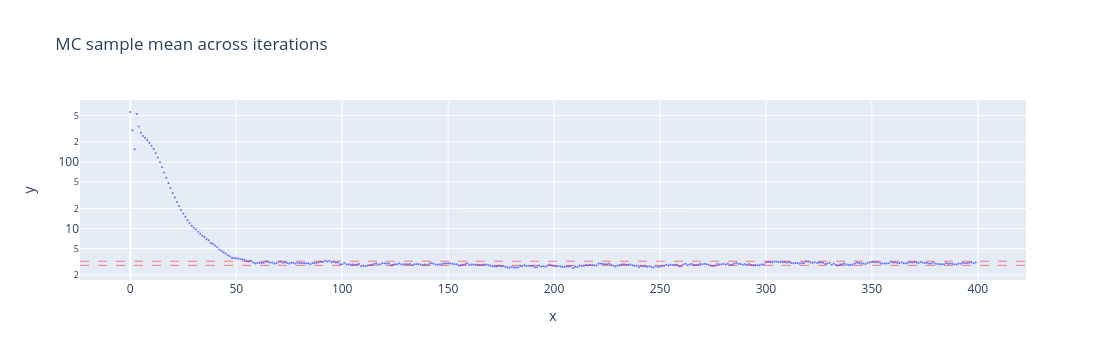

In [28]:
fig = ex.scatter(y=nees_by_iteration, log_y=True, title='MC sample mean across iterations')
fig.update_traces(marker_size=2)
fig.add_hline(y=conf_int[0], line_width=.5, line_dash="dash", line_color="red")
fig.add_hline(y=conf_int[1], line_width=.5, line_dash="dash", line_color="red")
fig

In the first 50 iterations KF is accumulating information about the target and converging towards a stable state. This is also where NEES is severly misaligned with the expected Chi-squared distribution.

In the second phase, in iterations 51 to 400, KF is more stable and seems to stay within the bounds of the confidence interval. However, there are two problems with that picture:

1. much less than 95% of the sample means are within the confidence interval, vs. the expected 95%
2. there seems to be a pattern in how the points are distributed

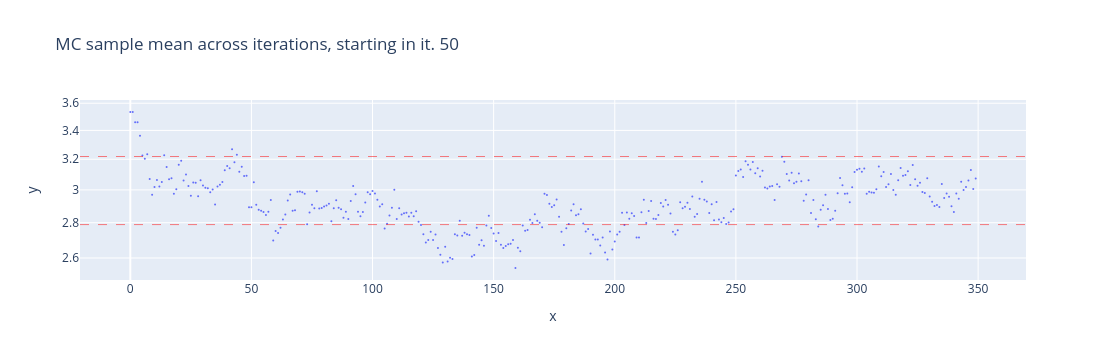

In [29]:
fig = ex.scatter(y=nees_by_iteration[50:], log_y=True, title='MC sample mean across iterations, starting in it. 50')
fig.update_traces(marker_size=2)
fig.add_hline(y=conf_int[0], line_width=.5, line_dash="dash", line_color="red")
fig.add_hline(y=conf_int[1], line_width=.5, line_dash="dash", line_color="red")
fig

### Less than 95% sample means within the bounds

For $N=100$ (number of MC runs) only 90% of samples are within the confidence interval. For $N=500$, only 76% of samples are within that interval. Clearly, this EKF is not entirely consistent.

In [12]:
def between(a, x1, x2):
    return (a >= x1) & (a <= x2)

np.mean(between(nees_by_iteration, *conf_int))

0.665

In [13]:
np.mean(between(nees_by_iteration, *conf_int)[50:])

0.76

### Points not distributed purely randomly

Let's compare the above plot of sample means with a plot of points samples with the matching Chi-squared distribution.

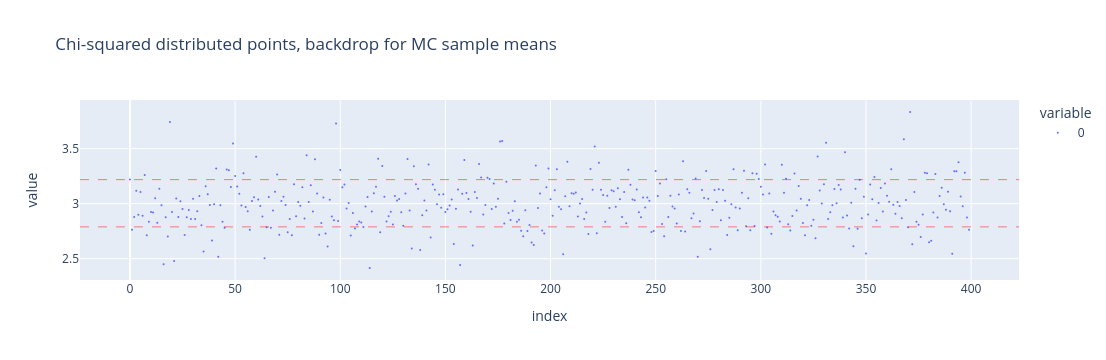

In [30]:
fig = ex.scatter(np.random.chisquare(300, 400) / 100, title='Chi-squared distributed points, backdrop for MC sample means')
fig.update_traces(marker_size=2)
fig.add_hline(y=conf_int[0], line_width=.5, line_dash="dash", line_color="red")
fig.add_hline(y=conf_int[1], line_width=.5, line_dash="dash", line_color="red")
fig

I expect that the pattern observable in the previous plot (sample means) can be (at least partially) explained by the magnitude of the estimation errors not constant throughout a single run. The magnitude of angle-related errors depends on the range between sensor and target. In the Cartesian space, this is most clearly visible on the Y axis.

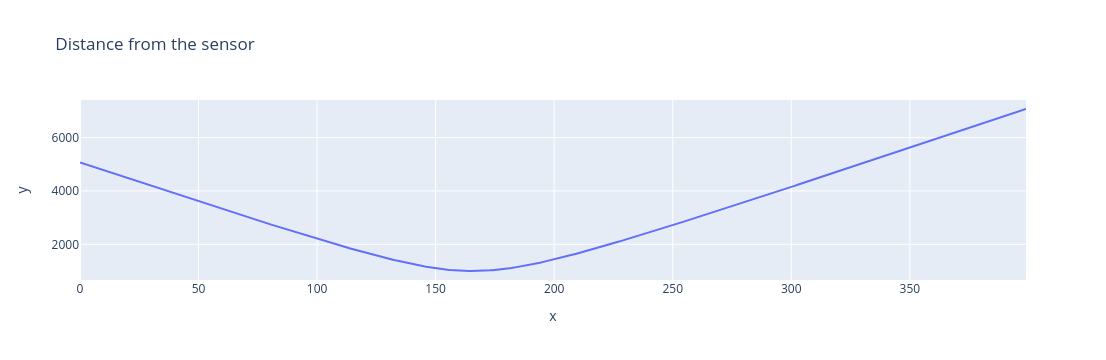

In [15]:
ex.line(y=np.sqrt(np.power(truth[1:,:], 2).sum(axis=1)), title="Distance from the sensor")

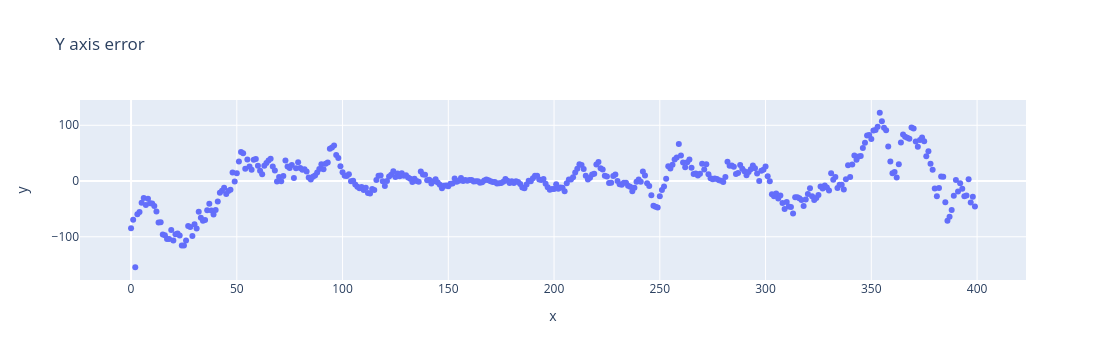

In [16]:
ex.scatter(y=x_hat[0,:,1] - truth[1:,1], title="Y axis error")

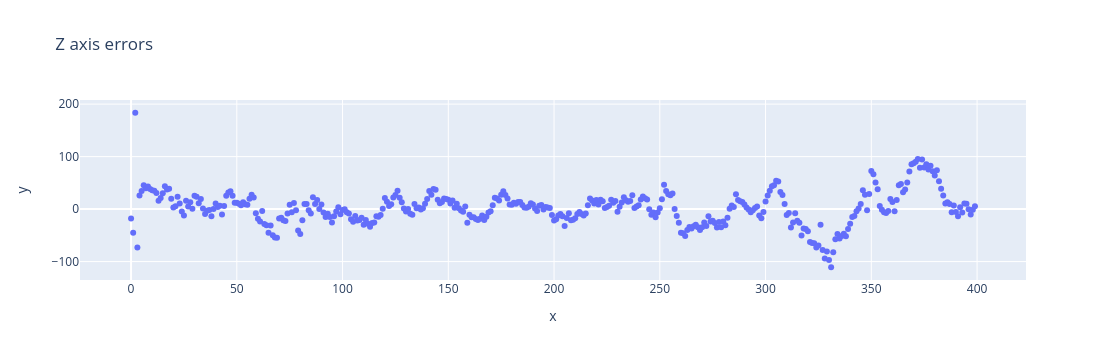

In [17]:
ex.scatter(y=x_hat[0,:,2] - truth[1:,2], title="Z axis errors")

## Match samples with chi2 pdf

What does an empirical cumulative distribution function (CDF) look like, when collected for our EKF and $k=200$, and how does it compare to the theoretical CDF of the $\mathcal{X}^2$ distribution?

In [18]:
smpl = sp.stats.ecdf(nees[200,:])
x = smpl.cdf.quantiles
chi2 = sp.stats.chi2.cdf(x, df=3)
ecdf = smpl.cdf.probabilities

In [19]:
plot_df = to_df(np.array((x, chi2, ecdf)).T, columns=['x', 'chi2', 'ecdf'])
plot_df

x      chi2   ecdf
0     0.036028  0.001799  0.002
1     0.050583  0.002980  0.004
2     0.219120  0.025555  0.006
3     0.259276  0.032504  0.008
4     0.334843  0.046652  0.010
..         ...       ...    ...
495   9.462055  0.976262  0.992
496  10.154735  0.982704  0.994
497  10.169083  0.982818  0.996
498  10.239358  0.983363  0.998
499  15.893411  0.998808  1.000

[500 rows x 3 columns]

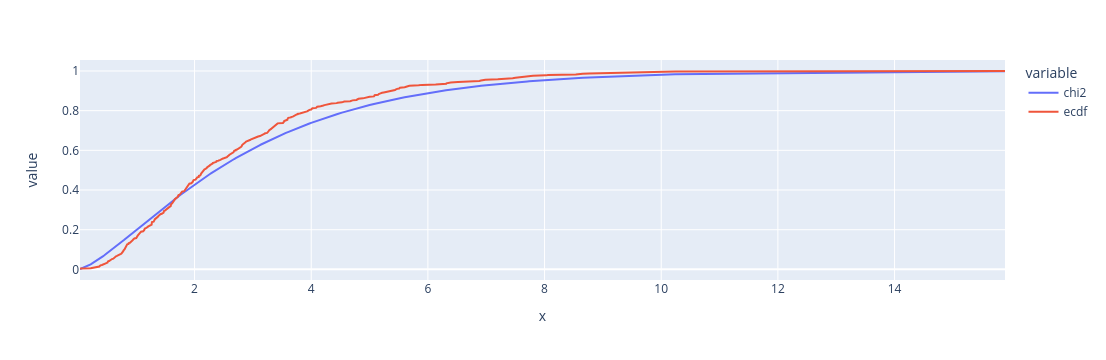

In [20]:
plot_df_melted = plot_df.melt(['x'], ['chi2', 'ecdf'])
ex.line(plot_df_melted, x='x', y='value', color='variable')

We can see a clear divergence between the empirical and theoretical CDFs for, especially large for $x<8$, which slowly converges to zero as $x$ grows. This plot captures the pattern which we observed plotting sample means against the bars of the confidence interval.

### A number of iterations at once

Below we plot the empirica CDF for a number of iterations. They all diverge from the theoretical CDF, albeit each in a different way.

In [22]:
def plot_cdf(iters):
    fig = go.Figure()

    x = np.arange(0, 20, .05)
    fig.add_trace(go.Scatter(x=x, y=sp.stats.chi2.cdf(x, df=3), mode='lines', name='Chi2'))

    colors = colorscale(n=len(iters)+1)
    
    for i, iter in enumerate(iters):
        smpl = sp.stats.ecdf(nees[iter,:])
        x = smpl.cdf.quantiles
        y = smpl.cdf.probabilities
        
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=f'Iter {iter}', line=dict(color=colors[i])))

    return fig

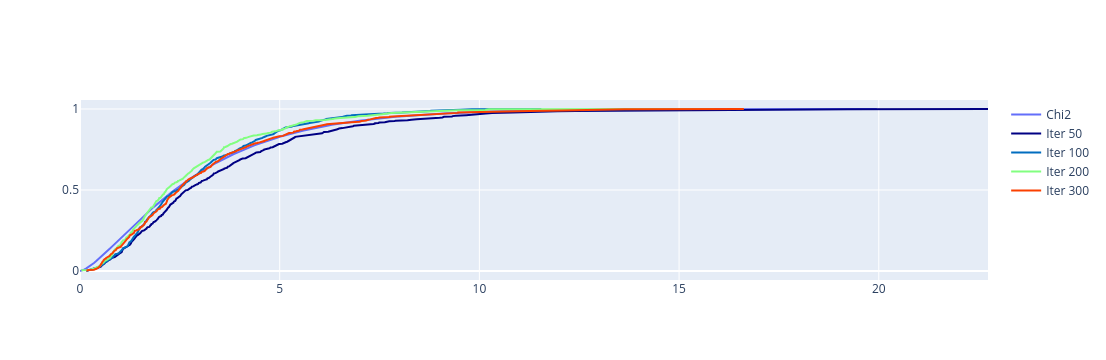

In [23]:
plot_cdf([50, 100, 200, 300])

### CDF error for a number of iterations

Now, let's plot the error between the empirical and theoretical CDFs. As expected, it is most pronounced for $x<8$. The area of each plot can be calculated to further aggregate the observed divergence. We do that in the next section.

In [24]:
def plot_cdf_err(iters):
    fig = go.Figure()
    colors = colorscale(n=len(iters)+1)
    
    for i, iter in enumerate(iters):
        smpl = sp.stats.ecdf(nees[iter,:])
        x = smpl.cdf.quantiles
        y = sp.stats.chi2.cdf(x, df=3) - smpl.cdf.probabilities
        
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=f'Iter {iter}', line=dict(color=colors[i])))

    return fig

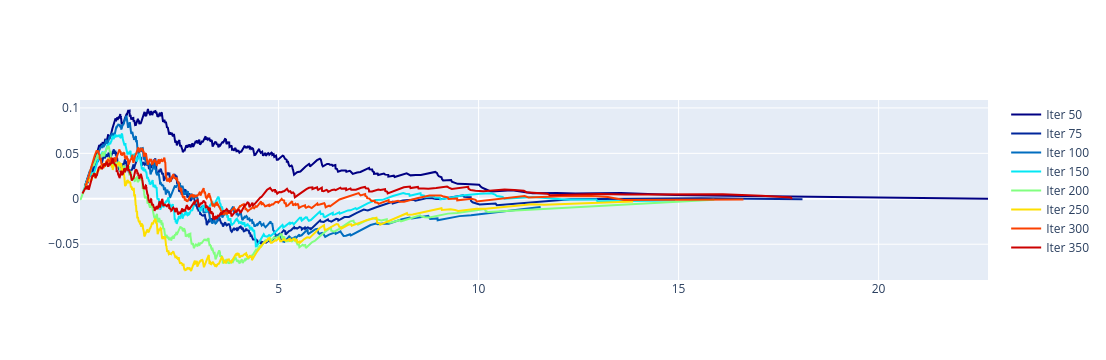

In [25]:
plot_cdf_err([50, 75, 100, 150, 200, 250, 300, 350])

### Cumulative CDF error across iterations

Now, for each iteration $k$ of the algorithm, we calculate the area below the error curve of the empirical CDF vs. the theoretical CDF. We then plot that number as the function of $k$.

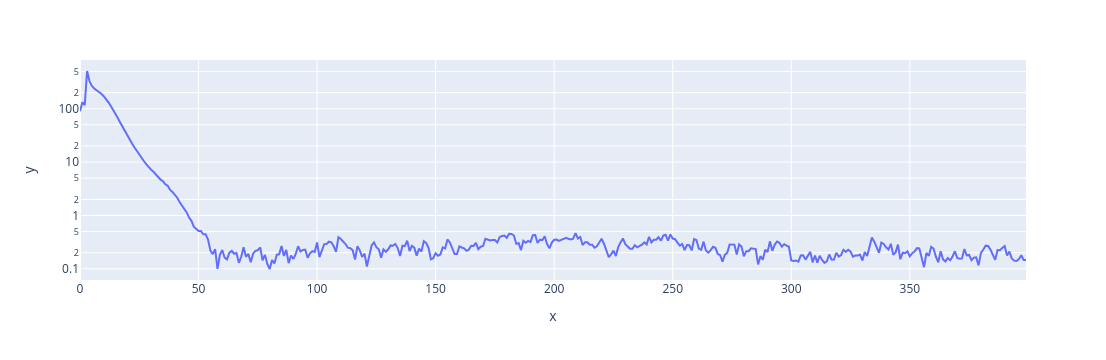

In [26]:
y = []
for i in range(nees.shape[0]):
    smpl = sp.stats.ecdf(nees[i,:])
    x = smpl.cdf.quantiles
    xd = np.diff(x)
    yd = np.abs(sp.stats.chi2.cdf(x, df=3) - smpl.cdf.probabilities)[1:]
    y.append(np.sum(xd * yd))

ex.line(x=range(nees.shape[0]), y=y, log_y=True)

Around iteration 55, the total area below the CDF error converges to what seems like a stable value.

# NMEE: Normalized Mean Estimation Error

Test components separately to see if they follow $N(0,1)$ (formulas 5.4.2-7 and 5.4.2-8).

In [94]:
nmee = (x_hat - truth[1:,:]) / np.sqrt(np.diagonal(P_hat, axis1=2, axis2=3))
nmee.shape

(500, 400, 6)

In [95]:
nmee_by_iter = nmee.mean(axis=0)
nmee_by_iter.shape

(400, 6)

In [105]:
conf_int = sp.stats.norm.ppf([0.025, 0.975], loc=0, scale=1/np.sqrt(MC_runs))
conf_int

array([-0.08765225,  0.08765225])

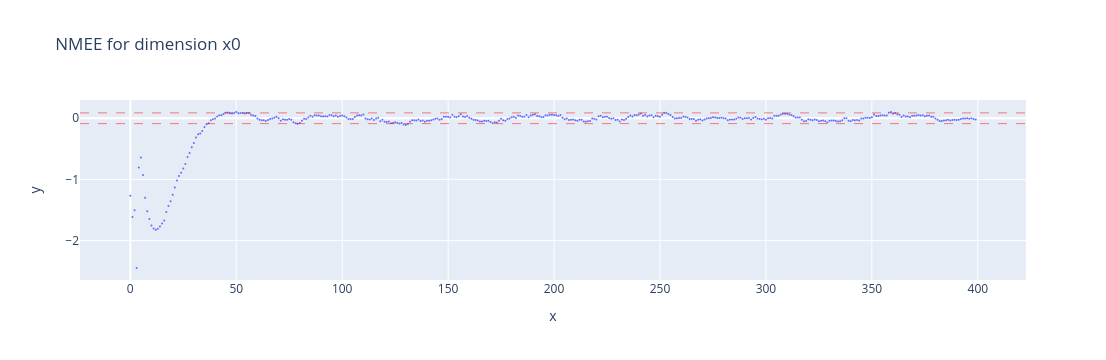

In [106]:
fig = ex.scatter(y=nmee_by_iter[:,0], title='NMEE for dimension x0')
fig.update_traces(marker_size=2)
fig.add_hline(y=conf_int[0], line_width=.5, line_dash="dash", line_color="red")
fig.add_hline(y=conf_int[1], line_width=.5, line_dash="dash", line_color="red")
fig

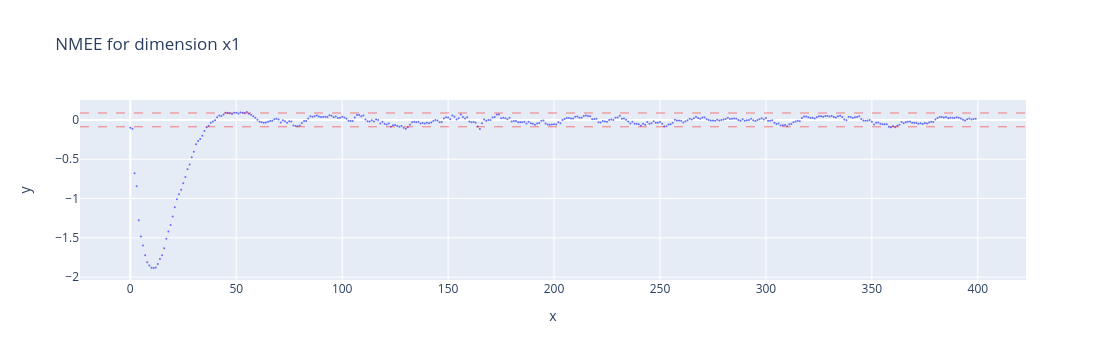

In [107]:
fig = ex.scatter(y=nmee_by_iter[:,1], title='NMEE for dimension x1')
fig.update_traces(marker_size=2)
fig.add_hline(y=conf_int[0], line_width=.5, line_dash="dash", line_color="red")
fig.add_hline(y=conf_int[1], line_width=.5, line_dash="dash", line_color="red")
fig

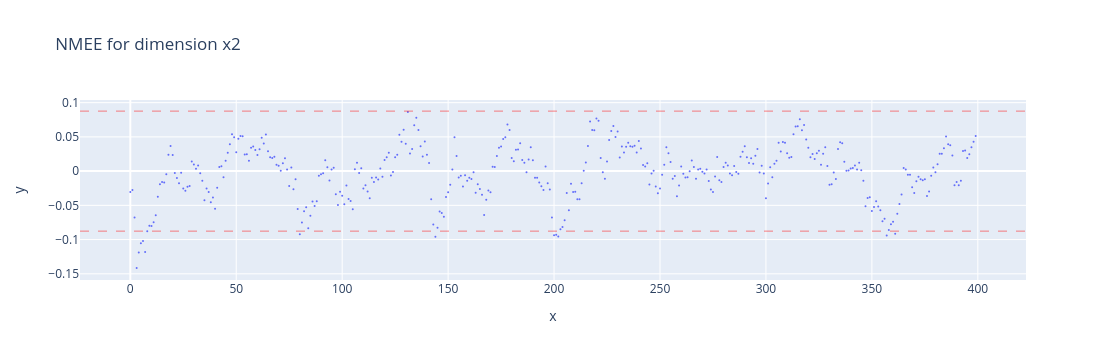

In [108]:
fig = ex.scatter(y=nmee_by_iter[:,2], title='NMEE for dimension x2')
fig.update_traces(marker_size=2)
fig.add_hline(y=conf_int[0], line_width=.5, line_dash="dash", line_color="red")
fig.add_hline(y=conf_int[1], line_width=.5, line_dash="dash", line_color="red")
fig

# NIS: Normalized Innovation Squared

In [43]:
v, S = [], []
MC_runs = 500

for run in range(MC_runs):

    measurements = rbe_measurements(truth[:,:3], noise_covariance=meas_cov, seed=run)
    v_run, S_run = [], []
    
    kf = ExtendedKalmanFilter()
    kf.initialize(measurements[0,:], meas_cov)
    
    for z in measurements[1:,:]:
        kf.predict(1)
            
        kf.update(z, meas_cov)

        v_run.append(np.copy(kf.v))
        S_run.append(np.copy(kf.S)) 
    
    v_run, S_run = np.array(v_run).squeeze(), np.array(S_run).squeeze()
    v.append(v_run)
    S.append(S_run)

v = np.array(v).squeeze()
S = np.array(S).squeeze()

In [52]:
# inverts only the last two dimensions, see:
# https://numpy.org/doc/stable/reference/routines.linalg.html#linear-algebra-on-several-matrices-at-once
S_inv = np.linalg.inv(S)

nis = []

for i in range(v.shape[1]):
    d = v[:,i,:]
    d = np.expand_dims(d, 2) # turn into a column vector
    nis_scores = np.matmul(np.matmul(d.transpose(0, 2, 1), S_inv[:,i,:,:]), d).squeeze()
    nis.append(nis_scores)

nis = np.array(nis).squeeze()

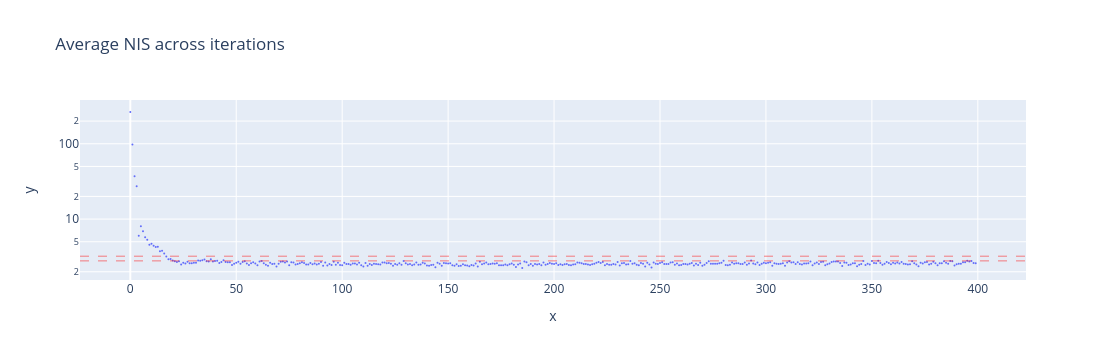

In [56]:
# 3 spatial dimensions and MC_runs Monte-Carlo runs
conf_int = sp.stats.chi2.ppf([0.025, 0.975], 3*MC_runs) / MC_runs
nis_by_iteration = nis.mean(axis=1)

fig = ex.scatter(y=nis_by_iteration, log_y=True, title='Average NIS across iterations')
fig.update_traces(marker_size=2)
fig.add_hline(y=conf_int[0], line_width=.5, line_dash="dash", line_color="red")
fig.add_hline(y=conf_int[1], line_width=.5, line_dash="dash", line_color="red")
fig

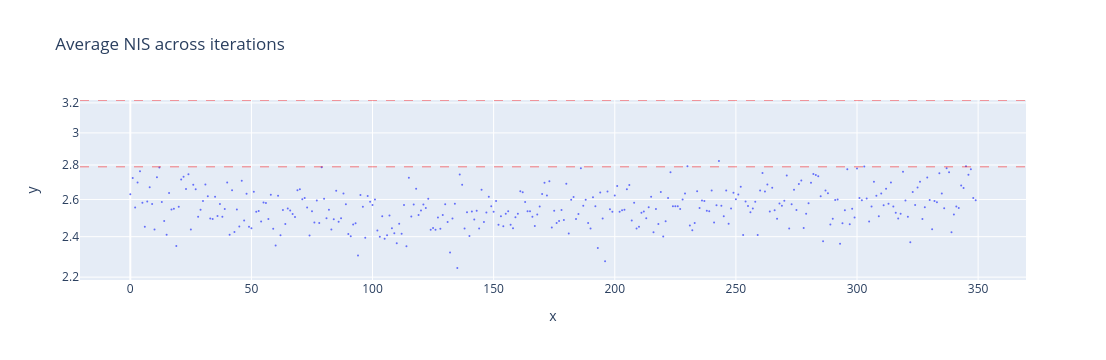

In [57]:
fig = ex.scatter(y=nis_by_iteration[50:], log_y=True, title='Average NIS across iterations')
fig.update_traces(marker_size=2)
fig.add_hline(y=conf_int[0], line_width=.5, line_dash="dash", line_color="red")
fig.add_hline(y=conf_int[1], line_width=.5, line_dash="dash", line_color="red")
fig

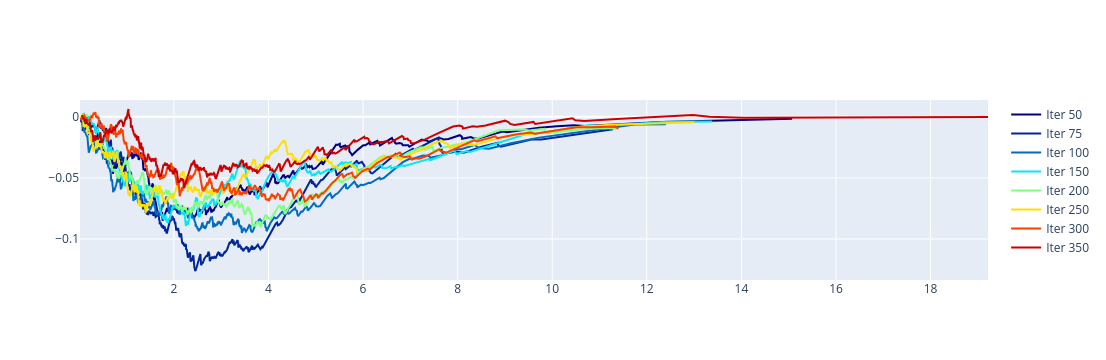

In [61]:
def plot_nis_cdf_err(iters):
    fig = go.Figure()
    colors = colorscale(n=len(iters)+1)
    
    for i, iter in enumerate(iters):
        smpl = sp.stats.ecdf(nis[iter,:])
        x = smpl.cdf.quantiles
        y = sp.stats.chi2.cdf(x, df=3) - smpl.cdf.probabilities
        
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=f'Iter {iter}', line=dict(color=colors[i])))

    return fig

plot_nis_cdf_err([50, 75, 100, 150, 200, 250, 300, 350])

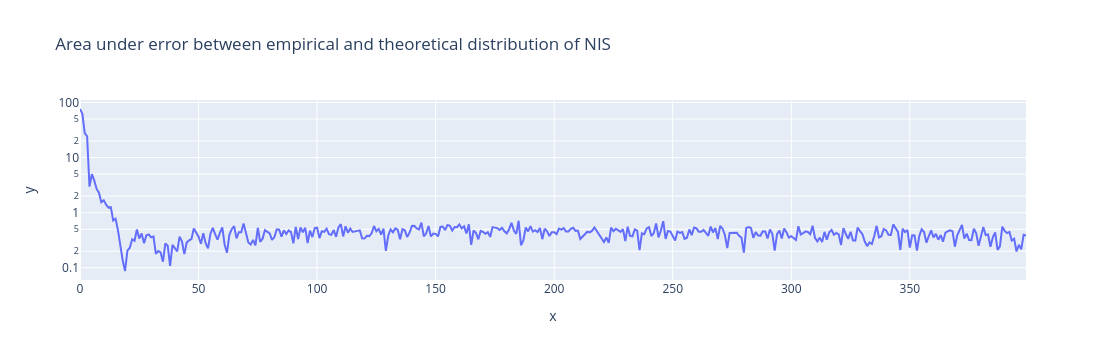

In [60]:
y = []
for i in range(nis.shape[0]):
    smpl = sp.stats.ecdf(nis[i,:])
    x = smpl.cdf.quantiles
    xd = np.diff(x)
    yd = np.abs(sp.stats.chi2.cdf(x, df=3) - smpl.cdf.probabilities)[1:]
    y.append(np.sum(xd * yd))

ex.line(x=range(nis.shape[0]), y=y, log_y=True, title='Area under error between empirical and theoretical distribution of NIS')

# TODO

* test whether innovation is acceptable as white